In [13]:
import pandas as pd
import numpy as np
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import time
import matplotlib.pyplot as plt
import math
import copy
from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import ProcessPoolExecutor
from tensorflow.keras.layers import Input
from sklearn.preprocessing import StandardScaler
from keras.layers import Dropout

In [14]:
# HIPERPARÂMETROS:
start_date = '2013-08-21'
W = 80  # Lembrando que o tamanho do treinamento será W - w
w = 50  

[*********************100%%**********************]  1 of 1 completed


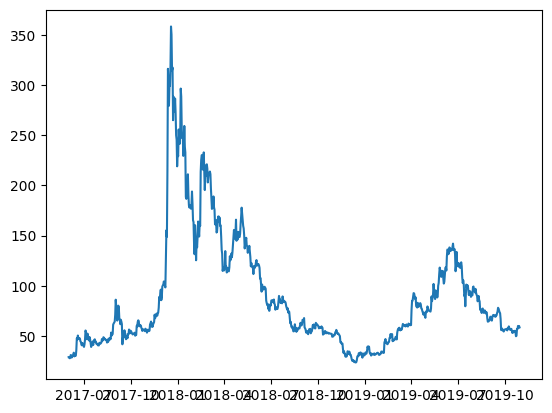

In [15]:
df = yf.download('LTC-USD', start=start_date, end=pd.to_datetime("today").strftime("%Y-%m-%d"), interval='1d')
plt.plot(df['Close'].loc['2017-06-01':'2019-10-30'])

In [16]:
# Criptomoedas que vamos escolher para nosso portifólio
cryptos = [
    'BTC-USD', 'LTC-USD'
]

In [17]:
## Função para calcular o retorno logarítmico
def log_return(series):
    return np.log(series['Close'] / series['Open'])

In [18]:
data = {}
for crypto in cryptos:
    # Baixar dados e calcular retorno logarítmico
    df = yf.download(crypto, start=start_date, end=pd.to_datetime("today").strftime("%Y-%m-%d"), interval='1d')
    df['Return'] = log_return(df)

    # Construir DataFrame final, pegando o retorno do dia anterior e o atual
    df_final = pd.DataFrame({
        #'Volume': df['Volume'],
        'Crypto_Return_Today': df['Return']
    }).dropna()

    data[crypto] = df_final

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [19]:
data['LTC-USD']

,Crypto_Return_Today
Date,
2014-09-17,-0.005390
2014-09-18,-0.078024
2014-09-19,-0.079802
2014-09-20,-0.009926
2014-09-21,-0.004031
...,...
2024-11-05,-0.000798
2024-11-06,0.081865
2024-11-07,0.006597


In [20]:
data_complete = {}
for crypto in cryptos:
    # Baixar dados e calcular retorno logarítmico
    df = yf.download(crypto, start=start_date, end=pd.to_datetime("today").strftime("%Y-%m-%d"), interval='1d')
    df['Return'] = log_return(df)

    # Construir DataFrame final, pegando o retorno do dia anterior e o atual
    df_final = pd.DataFrame({
        #'Volume': df['Volume'],
        'Crypto_Return_Today': df['Return']
    }).dropna()

    # Adicionar a coluna 'exp_value' com valores NaN
    df_final['exp_value'] = np.nan

    # Armazenar no dicionário
    data_complete[crypto] = df_final

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [21]:
print(len(data_complete['LTC-USD']))
data_complete['LTC-USD']

3707


,Crypto_Return_Today,exp_value
Date,,
2014-09-17,-0.005390,NaN
2014-09-18,-0.078024,NaN
2014-09-19,-0.079802,NaN
2014-09-20,-0.009926,NaN
2014-09-21,-0.004031,NaN
...,...,...
2024-11-05,-0.000798,NaN
2024-11-06,0.081865,NaN
2024-11-07,0.006597,NaN


In [22]:
# Criando a função First Transformation, que recebe uma tabela contendo os retornos de todos os dias dos ultimos X anos e retorno um vetor, que cada elemento
# é uma tabela do retorno de W+1 dias.
def FirstTransform(df, W):
    vet = []
    Linhas, Colunas = df.shape
    for i in range(Linhas, W+1, -1):
        vet.append(df.iloc[(i-W-1):i])
    return vet

In [23]:
# Aqui eu perco W+1 dias do meu dataset
for crypto in cryptos:
    data[crypto] = FirstTransform(data[crypto], W)

In [24]:
print(len(data['LTC-USD']))
data['LTC-USD'][0]

3626


,Crypto_Return_Today
Date,
2024-08-21,-0.003081
2024-08-22,-0.007037
2024-08-23,0.036452
2024-08-24,0.005689
2024-08-25,-0.026394
...,...
2024-11-05,-0.000798
2024-11-06,0.081865
2024-11-07,0.006597


## 2.2 Separar em treinamento e teste - Permitir Bagging

In [25]:
test_target = {}
for crypto in cryptos:
    row = []
    for i in range(len(data[crypto])):
        row.append((pd.DataFrame(data[crypto][i].iloc[-1])).T)
        data[crypto][i] = data[crypto][i].drop(data[crypto][i].index[-1])
    test_target[crypto] = row

In [26]:
data['LTC-USD'][0], test_target['LTC-USD'][0]['Crypto_Return_Today']

(            Crypto_Return_Today
 Date                           
 2024-08-21            -0.003081
 2024-08-22            -0.007037
 2024-08-23             0.036452
 2024-08-24             0.005689
 2024-08-25            -0.026394
 ...                         ...
 2024-11-04            -0.021437
 2024-11-05            -0.000798
 2024-11-06             0.081865
 2024-11-07             0.006597
 2024-11-08             0.018171
 
 [80 rows x 1 columns],
 2024-11-09    0.017163
 Name: Crypto_Return_Today, dtype: float64)

## 2.3 Bagging

In [27]:
# Definindo uma função bagging, que recebe um dataframe e retorna um vetor de dataframes.
def Bagging(df, n, gamma):
    df_bagged = []
    for i in range(gamma):
        aux = df.sample(n = n, random_state = i)
        aux = aux.sort_index()
        df_bagged.append(aux)
    return df_bagged

# 3. Machine Learning

* vamos peimeiro fazer do modo 1 para todos os dias
* depois aplicar para os ultimos 290 dias o modo 2 (contém bagging e purge K-Fold-CV)

## 3.1 Função do Modelo


In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau
# Arquitetura 1 e 2:
def create_model(a, b):
    model = Sequential()
    model.add(Input(shape=(a, b)))  # Define a camada de entrada
    model.add(LSTM(units=1, return_sequences=False))  # Primeira camada LSTM
    model.add(Dropout(0.2))
    model.add(Dense(units=1))  # Camada de saída
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


In [29]:
# Função do modelo LSTM
def Model(df, time_step, features, model=None):
    # Normalizando o dataframe
    #scaler = StandardScaler()
    #df_scaled = scaler.fit_transform(df)
    #df_array = np.array(df_scaled)
    df_array = np.array(df)

    # Transformando no formato LSTM
    X_lstm = []
    y_lstm = []
    for i in range(time_step, len(df_array)):
        X_lstm.append(df_array[i-time_step:i, :])  # Pega 'timesteps' linhas anteriores
        y_lstm.append(df_array[i])  # Alvo é o valor do dia seguinte
    X_lstm = np.array(X_lstm)
    y_lstm = np.array(y_lstm)

    # Separar o X_train (todos exceto o último elemento)
    X_train = X_lstm[:-1]
    y_train = y_lstm[:-1]
    y_train = pd.DataFrame(y_train)[features - 1].to_numpy()
    y_train = y_train.reshape((len(y_train), 1))
    y_train.shape

    # X_test e y_test
    X_test = X_lstm[-1:]
    y_test = y_lstm[-1:]
    y_test = y_lstm[-1:]
    y_test = pd.DataFrame(y_test)[features - 1].to_numpy()
    y_test = y_test.reshape((len(y_test), 1))

    # Treinar o modelo específico para a criptomoeda

    # Arquitetura 1:
    #reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, min_lr=1e-6, verbose=0)
    #model.fit(X_train, y_train, epochs=200, batch_size=32, verbose=0, callbacks=[reduce_lr])


    # Arquitetura 2:
    model.fit(X_train, y_train, epochs=50, verbose=0)
    # Fazer a previsão
    y_hat_scaled = model.predict(X_test)


    return y_hat_scaled

##  3.2 Treinamento com Paralelismo e Geração dos Expected Values

In [30]:
def Add(y_hat, data_complete, ind, crypto):
    data_complete[crypto].at[ind, 'exp_value'] = y_hat

In [31]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("Usando GPU:", physical_devices[0])
else:
    print("Usando CPU")

Usando CPU


In [32]:
for crypto in cryptos:
    print(len(data[crypto]))
len(data['LTC-USD'][0])

3626
3626


80

In [38]:
test_target['LTC-USD'][2718]
test_target['LTC-USD'][1837]

,Crypto_Return_Today
2019-10-30,-0.024423


In [41]:
test_target['LTC-USD'][2718]
test_target['LTC-USD'][2500]

,Crypto_Return_Today
2018-01-05,0.033603


In [ ]:
# Função que processa cada criptomoeda (paralelismo será aplicado aqui)
def process_crypto(crypto, data, test_target, data_complete, time_step, features):
    # Criar um modelo para cada criptomoeda
    for day in range(2500, 2718):
        model = create_model(time_step, features)

        df_train = data[crypto][day].copy()  # df é uma tabela de 300 linhas e uma coluna
        df_test = test_target[crypto][day].copy()  # df_test é uma tabela com 1 linha e uma coluna
        df = pd.concat([df_train, df_test], ignore_index=True)  # Unindo as duas tabelas

        scaler = StandardScaler()
        df = scaler.fit_transform(df)

        y_hat_scaled = Model(df, time_step, features, model=model)  # Chamar o modelo para previsão

        y_hat_scaled = np.repeat(y_hat_scaled, features, axis=1)
        y_hat_scaled = pd.DataFrame(y_hat_scaled, columns=(['Predictions_1']))

        y_hat = scaler.inverse_transform(y_hat_scaled)[0][features - 1]

        Add(y_hat, data_complete, df_test.index[0], crypto)  # Adicionar o resultado na tabela final

    print("\nMoeda: ", crypto, " processada")

# Número de samples que vamos testar o modelo
time_step = w
features = 1

# Criar o executor para rodar as criptomoedas em paralelo
with ThreadPoolExecutor() as executor:
    # Executar o processo para cada criptomoeda simultaneamente
    futures = [
        executor.submit(process_crypto, crypto, data, test_target, data_complete, time_step, features)
        for crypto in cryptos
    ]

    # Aguardar a conclusão de todas as threads
    for future in futures:
        future.result()

print("Processamento em paralelo finalizado.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

13min para 100 dias

In [139]:
df = data_complete['BTC-USD']
df.dropna()

,Crypto_Return_Today,exp_value
Date,,
2017-06-02,0.034554,0.004293
2017-06-03,0.008636,0.010793
2017-06-04,-0.014223,0.010484
2017-06-05,0.067116,0.010444
2017-06-06,0.062086,0.013904
...,...,...
2017-11-05,0.000390,0.011636
2017-11-06,-0.052759,0.018383
2017-11-07,0.017121,0.006895


In [141]:
data_visual = {}
for crypto in cryptos:
    data_visual[crypto] = pd.read_csv(f"{crypto}.csv", index_col='Date')
    data_visual[crypto] = data_visual[crypto][~data_visual[crypto].index.duplicated(keep='first')]

In [142]:
data_visual = data_complete

In [143]:
for crypto in cryptos:
    df = data_visual[crypto]
    df['ae'] = df['exp_value'] - df['Crypto_Return_Today']
    df['ae'] = abs(df['ae'])
    df = df.dropna()
    num_positive = (df['Crypto_Return_Today'] > 0).sum()
    num_negative = (df['Crypto_Return_Today'] < 0).sum()

    hat_pos = (df['exp_value'] > 0).sum()
    hat_neg = (df['exp_value'] < 0).sum()


    TP = ((df['Crypto_Return_Today'] > 0)  & (df['exp_value'] > 0)).sum()
    TN = ((df['Crypto_Return_Today'] < 0)  & (df['exp_value'] < 0)).sum()
    FP = ((df['Crypto_Return_Today'] < 0)  & (df['exp_value'] > 0)).sum()
    FN = ((df['Crypto_Return_Today'] > 0)  & (df['exp_value'] < 0)).sum()

    #rmse = np.sqrt(((df['Crypto_Return_Today'] - df['exp_value']) ** 2).mean())
    print("\n\n--------------------------------------------------------")
    print("\n\nCriptomoeda: ", crypto)
    print("\n                              Real")
    print("\nNumero de Subidas: ",num_positive,"   |   ",100*num_positive / (num_negative + num_positive),"%")
    print("\nNumero de Quedas : ",num_negative,"   |   ",100*num_negative / (num_negative + num_positive),"%")

    print("\n                              Predito")
    print("\nNumero de Subidas: ",hat_pos,"   |   ", 100*hat_pos / (hat_neg + hat_pos),"%")
    print("\nNumero de Quedas : ",hat_neg,"   |   ", 100*hat_neg / (hat_neg + hat_pos),"%")

    print("\nMean Absolute Error MAE: ", df['ae'].mean())
    #print("\nRoot Mean Squared Error RMSE: ", rmse)
    print("\nAcc: ", (TP+TN) / (TP + FP + FN + FP))
    print("\nSen: ", (TP) / (TP + FN)) # significa, entre os que subiram, quantos % eu consegui identificar que realmente subiu
    print("\nSpe: ", (TP) / (TP + FN)) # significa, entre os que cairam, quantos % eu consegui identificar que realmente caiu
    print("\nPre: ", (TP) / (TP + FP)) # significa, entre os que eu disse que ia subir, quantos % realmente subiram

    TP = ((df['Crypto_Return_Today'] > 0)  & (df['exp_value'] > 0) & (df['exp_value'] >= 0.0002)).sum()
    FP = (((df['Crypto_Return_Today'] < 0)  & (df['exp_value'] > 0)) & (df['exp_value'] >= 0.0002)).sum()

    limite_90 = df['exp_value'].quantile(0.9)
    menor_valor_10_maiores = df[df['exp_value'] >= limite_90]['exp_value'].min()
    print("\nLower bound dos 10% maiores: ", menor_valor_10_maiores)

    print("\nPrecisao para maiores que 0.008: ", (TP) / (TP + FP)) # significa, entre os que eu disse que ia subir, quantos % realmente subiram



--------------------------------------------------------


Criptomoeda:  BTC-USD

                              Real

Numero de Subidas:  91    |    56.52173913043478 %

Numero de Quedas :  70    |    43.47826086956522 %

                              Predito

Numero de Subidas:  136    |    84.472049689441 %

Numero de Quedas :  25    |    15.527950310559007 %

Mean Absolute Error MAE:  0.03490940029524216

Acc:  0.44878048780487806

Sen:  0.8681318681318682

Spe:  0.8681318681318682

Pre:  0.5808823529411765

Lower bound dos 10% maiores:  0.016180166974663734

Precisao para maiores que 0.008:  0.5808823529411765


--------------------------------------------------------


Criptomoeda:  LTC-USD

                              Real

Numero de Subidas:  79    |    49.06832298136646 %

Numero de Quedas :  82    |    50.93167701863354 %

                              Predito

Numero de Subidas:  107    |    66.45962732919254 %

Numero de Quedas :  54    |    33.54037267080745 %

Mean Abs

In [ ]:
for crypto in cryptos:
    data_complete[crypto]= data_complete[crypto][~data_complete[crypto].index.duplicated(keep='first')]

In [144]:
data_complete['LTC-USD'].dropna()

,Crypto_Return_Today,exp_value,ae
Date,,,
2017-06-02,0.001639,0.017108,0.015469
2017-06-03,-0.048523,0.014159,0.062683
2017-06-04,0.010398,0.003589,0.006808
2017-06-05,0.093506,-0.001202,0.094708
2017-06-06,-0.009438,0.040499,0.049936
...,...,...,...
2017-11-05,-0.005089,0.002981,0.008069
2017-11-06,0.007541,0.000822,0.006719
2017-11-07,0.108592,0.003583,0.105009


In [145]:
data_aux = {}
for crypto in cryptos:
    data_aux[crypto] = pd.read_csv(f"{crypto}.csv", index_col='Date')
    #data_complete[crypto] = pd.read_csv(f"{crypto}.csv")

In [146]:
data_aux['LTC-USD'].dropna()

,Crypto_Return_Today,exp_value,ae
Date,,,
2017-11-10,-0.083739,0.005625,0.089364
2017-11-11,0.048581,0.008191,0.040390
2017-11-12,-0.054480,0.007363,0.061843
2017-11-13,0.036840,0.001265,0.035575
2017-11-14,0.016678,0.005912,0.010766
...,...,...,...
2018-08-31,0.024566,-0.009073,0.033638
2018-09-01,0.065999,-0.004090,0.070089
2018-09-02,-0.005096,-0.003769,0.001327


In [161]:
data_aux['LTC-USD'][1150:]
#data_complete['LTC-USD'][:1150]

,Crypto_Return_Today,exp_value,ae
Date,,,
2017-11-10,-0.083739,0.005625,0.089364
2017-11-11,0.048581,0.008191,0.040390
2017-11-12,-0.054480,0.007363,0.061843
2017-11-13,0.036840,0.001265,0.035575
2017-11-14,0.016678,0.005912,0.010766
...,...,...,...
2024-10-28,-0.005068,NaN,NaN
2024-10-29,0.045062,NaN,NaN
2024-10-30,-0.029316,NaN,NaN


In [162]:
for crypto in cryptos:
    df_aux = data_complete[crypto]
    df_aux = pd.concat([df_aux[:1150], data_aux[crypto][1150:]])
    df_aux.index = pd.to_datetime(df_aux.index)
    data_complete[crypto] = df_aux

In [163]:
for crypto in cryptos:
    data_complete[crypto]= data_complete[crypto][~data_complete[crypto].index.duplicated(keep='first')]

In [164]:
data_complete['LTC-USD'].dropna()

,Crypto_Return_Today,exp_value,ae
Date,,,
2017-06-02,0.001639,0.017108,0.015469
2017-06-03,-0.048523,0.014159,0.062683
2017-06-04,0.010398,0.003589,0.006808
2017-06-05,0.093506,-0.001202,0.094708
2017-06-06,-0.009438,0.040499,0.049936
...,...,...,...
2018-08-31,0.024566,-0.009073,0.033638
2018-09-01,0.065999,-0.004090,0.070089
2018-09-02,-0.005096,-0.003769,0.001327


In [165]:
for crypto in cryptos:
    # Define o nome do arquivo como o nome da criptomoeda seguido de .csv
    filename = f"{crypto}.csv"

    # Salva o DataFrame data_complete[crypto] no arquivo .csv
    data_complete[crypto].to_csv(filename, index=True)

    print(f"Arquivo {filename} salvo com sucesso!")

Arquivo BTC-USD.csv salvo com sucesso!
Arquivo LTC-USD.csv salvo com sucesso!


gerar uns graficos aqui

In [172]:
results = []

for crypto in cryptos:
    df = data_visual[crypto]
    df['ae'] = df['exp_value'] - df['Crypto_Return_Today']
    df['ae'] = abs(df['ae'])
    df = df.dropna()
    
    # Cálculos dos valores
    num_positive = (df['Crypto_Return_Today'] > 0).sum()
    num_negative = (df['Crypto_Return_Today'] < 0).sum()
    hat_pos = (df['exp_value'] > 0).sum()
    hat_neg = (df['exp_value'] < 0).sum()

    # Calcula a porcentagem de subidas e quedas reais e previstas
    total_real = num_positive + num_negative
    total_pred = hat_pos + hat_neg
    perc_positive_real = (100 * num_positive / total_real) if total_real > 0 else None
    perc_positive_pred = (100 * hat_pos / total_pred) if total_pred > 0 else None
    
    # Calcular métricas de avaliação
    TP = ((df['Crypto_Return_Today'] > 0) & (df['exp_value'] > 0)).sum()
    TN = ((df['Crypto_Return_Today'] < 0) & (df['exp_value'] < 0)).sum()
    FP = ((df['Crypto_Return_Today'] < 0) & (df['exp_value'] > 0)).sum()
    FN = ((df['Crypto_Return_Today'] > 0) & (df['exp_value'] < 0)).sum()
    mae = df['ae'].mean()
    acc = (TP + TN) / (TP + FP + FN + FP) if (TP + FP + FN + FP) > 0 else None
    sen = TP / (TP + FN) if (TP + FN) > 0 else None
    spe = TN / (TN + FP) if (TN + FP) > 0 else None
    pre = TP / (TP + FP) if (TP + FP) > 0 else None

    # Lower bound dos 10% maiores
    limite_90 = df['exp_value'].quantile(0.75)
    menor_valor_10_maiores = df[df['exp_value'] >= limite_90]['exp_value'].min()

    # Precisão para valores maiores que 0.008
    TP_threshold = ((df['Crypto_Return_Today'] > 0) & (df['exp_value'] > 0) & (df['exp_value'] >= menor_valor_10_maiores)).sum()
    FP_threshold = ((df['Crypto_Return_Today'] < 0) & (df['exp_value'] > 0) & (df['exp_value'] >= menor_valor_10_maiores)).sum()
    prec_maior_008 = TP_threshold / (TP_threshold + FP_threshold) if (TP_threshold + FP_threshold) > 0 else None

    # Adicionando os resultados para a criptomoeda atual
    results.append({
        "Crypto": crypto,
        "Num Subidas (Real)": num_positive,
        "Perc Subidas (Real)": perc_positive_real,
        "Num Quedas (Real)": num_negative,
        "Num Subidas (Pred)": hat_pos,
        "Perc Subidas (Pred)": perc_positive_pred,
        "Num Quedas (Pred)": hat_neg,
        "MAE": mae,
        "Acc": acc,
        "Sen": sen,
        "Spe": spe,
        "Pre": pre,
        "Lower bound dos 10% maiores": menor_valor_10_maiores,
        "Precisao para maiores que 0.008": prec_maior_008
    })

# Criando um DataFrame com os resultados
results_df = pd.DataFrame(results)

# Exibindo a tabela com os resultados

# Exibindo a tabela com os resultados
results_df.to_csv("resultado_arquitetura_1.csv", index = True)
results_df

,Crypto,Num Subidas (Real),Perc Subidas (Real),Num Quedas (Real),Num Subidas (Pred),Perc Subidas (Pred),Num Quedas (Pred),MAE,Acc,Sen,Spe,Pre,Lower bound dos 10% maiores,Precisao para maiores que 0.008
0,BTC-USD,256,55.652174,204,257,55.869565,203,0.036346,0.481405,0.558594,0.441176,0.55642,0.008878,0.652174
1,LTC-USD,217,47.173913,243,219,47.608696,241,0.049756,0.512249,0.474654,0.522634,0.47032,0.010085,0.460870


In [174]:
Pre_media = results_df['Pre'].mean()
Acc_media = results_df['Acc'].mean()
MAE_media = results_df['MAE'].mean()
Precisao_25_media = results_df['Precisao para maiores que 0.008'].mean()
print("Pre_media ", Pre_media)
print("Acc_media ", Acc_media)
print("MAE_media ", MAE_media)
print("Precisao_25_media", Precisao_25_media)

Pre_media  0.5133699340831157
Acc_media  0.49682720094240646
MAE_media  0.04305072093024476
Precisao_25_media 0.5565217391304348


## 3.3 Método 2 para os ultimos X intervalos

* Aplicar bagging
* Aplicar CV e Otimização de HP
* Fazer treinamento para uma janela W maior de tempo

In [ ]:
# for day in data[crypto]:
#       day = bagging(day)

# for day in data[crypto]:
#       for sample in day:
#               sample = CV(sample) # transforma sample em um vetor de folds. Ultimos 10% do fold são validation e 90% são pure train

# for day in data[crypto]:
#       for sample in day:
#               for fold in sample:
#                       y_hat = model(fold)
#               y_hat_mean = y_hat / len(sample)
#       y_hat_mean_mean = y_hat_mean / len(day)